# Analysis of machine learning results
This notebook analyze the prediction of the fitted machine learning algorithm based on the OTIM database.

In [1]:
#basic data handeling and plotting
import ast
import glob
import math
import os
import pickle
import random
import plotly
import statistics
from scipy import stats
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as s
from collections import Counter
from itertools import islice
from IPython.display import Image, Markdown, display
from tqdm.notebook import tqdm, trange

#data transformation and encoding
import category_encoders as ce
import optuna
from optuna.integration import LightGBMPruningCallback
from optuna.visualization import (plot_optimization_history, plot_intermediate_values,
                                  plot_parallel_coordinate, plot_param_importances)
# if plotly graph are not showing run: "juypter labextension install juypterlab-plotly" in the terminal
from BorutaShap import BorutaShap #change shuffle to false in source code to get close to strict cv
from missingpy import MissForest  # pip install git+https://github.com/berkeleyjess/missingpy@patch-1
# modify <python direcotry>/lib/site-packages/missingpy/knninpute.py at line 11: replace "sklearn.neighbors.base" by "sklearn.neighbors._base"
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    MinMaxScaler,
    Normalizer,
    OneHotEncoder,
    StandardScaler,
)

#models
from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor
from mlxtend.regressor import StackingCVRegressor
from sklearn.ensemble import (
    AdaBoostRegressor,
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    RandomForestRegressor,
)
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import PowerTransformer
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import StackingRegressor

#evaluation 
import shap
from sklearn.metrics import (
    confusion_matrix,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    RandomizedSearchCV,
    cross_val_predict,
    cross_val_score,
    cross_validate,
    train_test_split,
)

import warnings
warnings.simplefilter('ignore')

# working directory
data_dir = "../wd/"

# set seed for random vars as well as some basic aesthetics for plots and cv-split-number
seed = 420
tresh_outer = 10
sns.set(rc={"figure.figsize": (14, 6)}, font_scale=1.3)
sns.set_style("ticks")
# decimal output limit
%precision 3

#define available K
k_factors = [
    "log_Ks",
    "log_K1",
    "log_K2",
    "log_K3",
    "log_K4",
    "log_K5",
    "log_K6",
    "log_K7",
    "log_K8",
    "log_K9",
    "log_K10"
]

C:\Users\gblanchy\WPy64-3890\python-3.8.9.amd64\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\gblanchy\WPy64-3890\python-3.8.9.amd64\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\gblanchy\WPy64-3890\python-3.8.9.amd64\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\Users\gblanchy\WPy64-

## Some functions

In [2]:
def ABS_SHAP(df_shap, df):
    # Make a copy of the input data
    shap_v = df_shap
    feature_list = df_shap.columns
    df_v = df.copy()
    
    print(feature_list)
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(5,6),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")

## Load results from machine learning

In [3]:
# load database
df0 = pd.read_excel(data_dir + "KunsatDB_prep.xlsx")
df = df0.drop(['Month1_sin','Month1_cos','Month2_sin','Month2_cos'],1)

In [ ]:
# load ML results  
naivedir = data_dir + "Naive1/"
for i, k in enumerate(k_factors):
    dfnow = pd.read_csv(naivedir + k + "R2Summary_run" + str(9) + ".csv", delimiter=',')
    dfnow = dfnow.drop(columns=['median global R2', 'median local R2'])
    dfnow = dfnow.rename(columns={"universal R2": k})
    if i == 0:
        naive_univR2 = dfnow        
    else:
        naive_univR2 = pd.concat([naive_univR2, dfnow], axis = 1)
        
s1dir = data_dir + "Success1/"
for i, k in enumerate(k_factors):
    dfnow = pd.read_csv(s1dir + k + "R2Summary_run" + str(9) + ".csv", delimiter=',')
    dfnow = dfnow.drop(columns=['median global R2', 'median local R2'])
    dfnow = dfnow.rename(columns={"universal R2": k})
    if i == 0:
        s1_univR2 = dfnow        
    else:
        s1_univR2 = pd.concat([s1_univR2, dfnow], axis = 1)
        
s2dir = data_dir + "Success2/"
for i, k in enumerate(k_factors):
    dfnow = pd.read_csv(s2dir + k + "R2Summary_run" + str(9) + ".csv", delimiter=',')
    dfnow = dfnow.drop(columns=['median global R2', 'median local R2'])
    dfnow = dfnow.rename(columns={"universal R2": k})
    if i == 0:
        s2_univR2 = dfnow        
    else:
        s2_univR2 = pd.concat([s2_univR2, dfnow], axis = 1)
        
s3dir = data_dir + "Success3/"
for i, k in enumerate(k_factors):
    dfnow = pd.read_csv(s3dir + k + "R2Summary_run" + str(9) + ".csv", delimiter=',')
    dfnow = dfnow.drop(columns=['median global R2', 'median local R2'])
    dfnow = dfnow.rename(columns={"universal R2": k})
    if i == 0:
        s3_univR2 = dfnow        
    else:
        s3_univR2 = pd.concat([s3_univR2, dfnow], axis = 1)
        
s4dir = data_dir + "Success4/"
for i, k in enumerate(k_factors):
    dfnow = pd.read_csv(s4dir + k + "R2Summary_run" + str(9) + ".csv", delimiter=',')
    dfnow = dfnow.drop(columns=['median global R2', 'median local R2'])
    dfnow = dfnow.rename(columns={"universal R2": k})
    if i == 0:
        s4_univR2 = dfnow        
    else:
        s4_univR2 = pd.concat([s4_univR2, dfnow], axis = 1)

s5dir = data_dir + "Success5/"
for i, k in enumerate(k_factors):
    dfnow = pd.read_csv(s5dir + k + "R2Summary_run" + str(9) + ".csv", delimiter=',')
    dfnow = dfnow.drop(columns=['median global R2', 'median local R2'])
    dfnow = dfnow.rename(columns={"universal R2": k})
    if i == 0:
        s5_univR2 = dfnow        
    else:
        s5_univR2 = pd.concat([s5_univR2, dfnow], axis = 1)
        
s6dir = data_dir + "Success5/"
for i, k in enumerate(k_factors):
    dfnow = pd.read_csv(s6dir + k + "R2Summary_run" + str(9) + ".csv", delimiter=',')
    dfnow = dfnow.drop(columns=['median global R2', 'median local R2'])
    dfnow = dfnow.rename(columns={"universal R2": k})
    if i == 0:
        s6_univR2 = dfnow
    else:
        s6_univR2 = pd.concat([s6_univR2, dfnow], axis = 1)

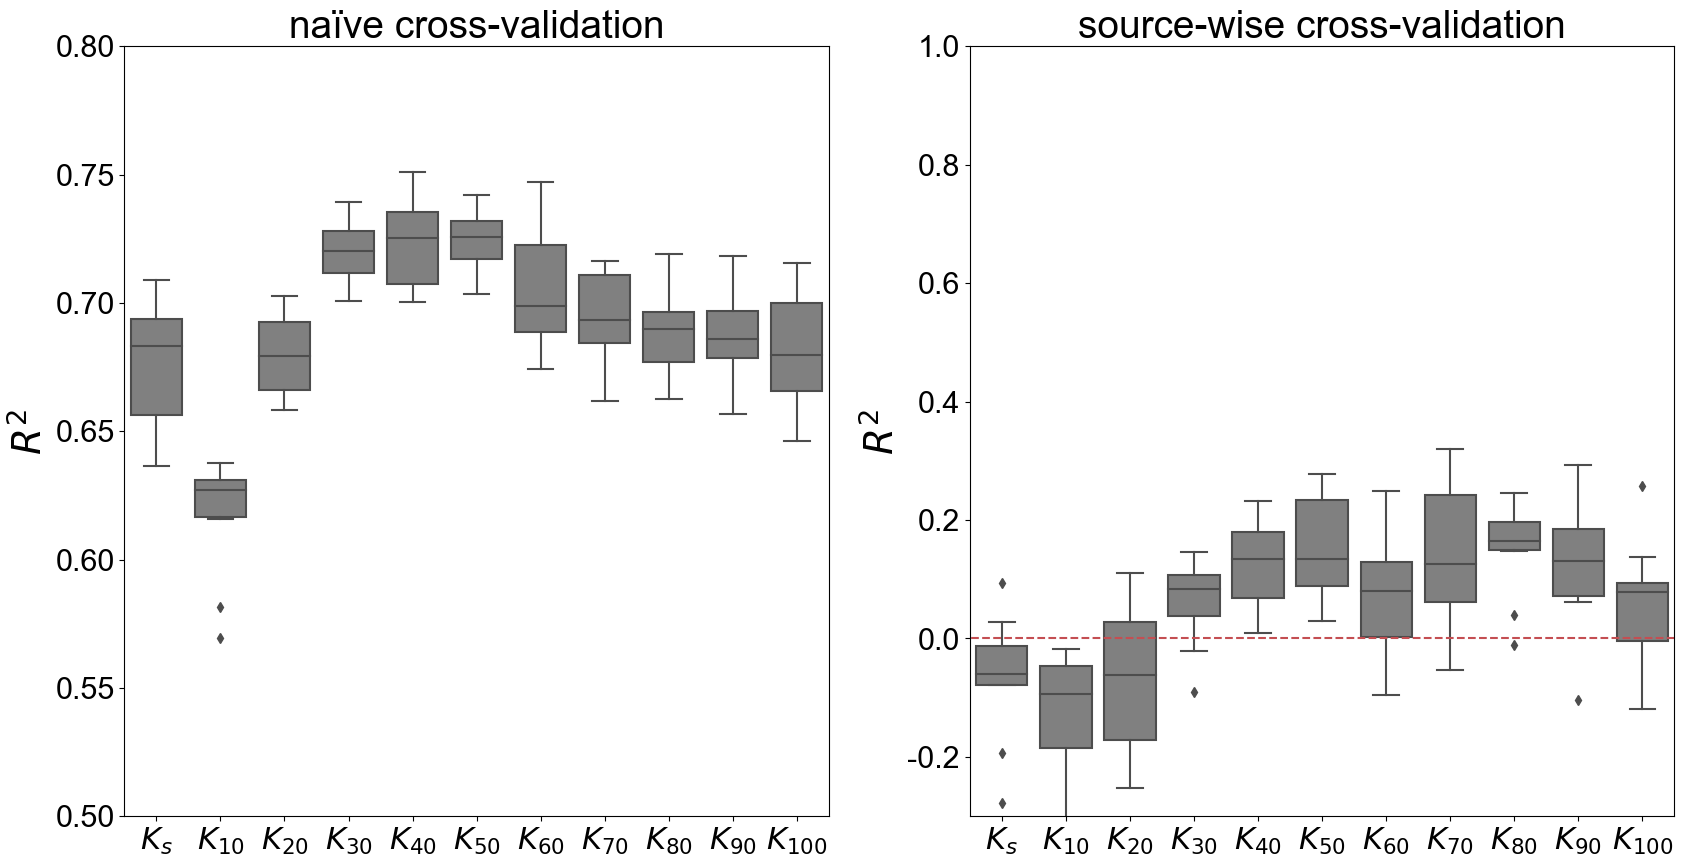

In [38]:
sdir = data_dir + "Success4/"
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
#fig.suptitle("Impact of cross-validation scheme")

labellist = []
for i in np.arange(0.5, 0.81, 0.05): labellist.append("{:.2f}".format(i))
g1 = sns.boxplot(x="variable", y="value", data=pd.melt(naive_univR2), ax=axes[0], color = 'grey')
g1.set(xlabel=None, ylim=(0.5, 0.8), title="naïve cross-validation")
g1.set_title("naïve cross-validation", fontname='Arial', fontsize=28)
g1.set_xticklabels(['$K_s$','$K_{10}$','$K_{20}$','$K_{30}$','$K_{40}$','$K_{50}$','$K_{60}$','$K_{70}$','$K_{80}$','$K_{90}$','$K_{100}$'], fontname='Arial', fontsize=22)
g1.set_ylabel("$R^2$", fontname='Arial', fontsize=28, fontweight="bold")
g1.set_yticks(np.arange(0.5, 0.81, 0.05))
g1.set_yticklabels(labellist, fontname='Arial', fontsize=22)

labellist = []
g2 = sns.boxplot(x="variable", y="value", data=pd.melt(s4_univR2), ax=axes[1], color = 'grey')
plt.plot([-1,11],[0,0],'--r')
g2.set(xlabel=None, ylim=(-0.3, 1), title="source-wise cross-validation")
g2.set_title("source-wise cross-validation", fontname='Arial', fontsize=28)
for i in np.arange(-0.2, 1.1, 0.2): labellist.append("{:.1f}".format(i))
g2.set_xticklabels(['$K_s$','$K_{10}$','$K_{20}$','$K_{30}$','$K_{40}$','$K_{50}$','$K_{60}$','$K_{70}$','$K_{80}$','$K_{90}$','$K_{100}$'], fontname='Arial', fontsize=22)
g2.set_xlim(-0.5, 10.5)
g2.set_ylabel("$R^2$", fontname='Arial', fontsize=28, fontweight="bold")
g2.set_yticks(np.arange(-0.2, 1.01, 0.2))
g2.set_yticklabels(labellist, fontname='Arial', fontsize=22)

plt.savefig(sdir + "Pics/PredictionPreformance", dpi=300, bbox_inches='tight')

In [6]:
s4dir = data_dir + "Success4/"
mypas = ['study2_num_leaves', 'study2_min_child_samples', 'study2_min_split_gain']

for i, k in enumerate(k_factors):
    for j in list(range(0,10)):
        dfnow = pd.read_csv(s4dir + k + "_run" + str(j) + ".csv", delimiter=',')
        dfnow = dfnow[mypas]      
        if i == 0 & j == 0:
            dfout = dfnow
        else:
            dfout = pd.concat([dfout, dfnow])    

dfout.median()

study2_num_leaves           27.000000
study2_min_child_samples    50.000000
study2_min_split_gain        0.050788
dtype: float64

## Load Shap values

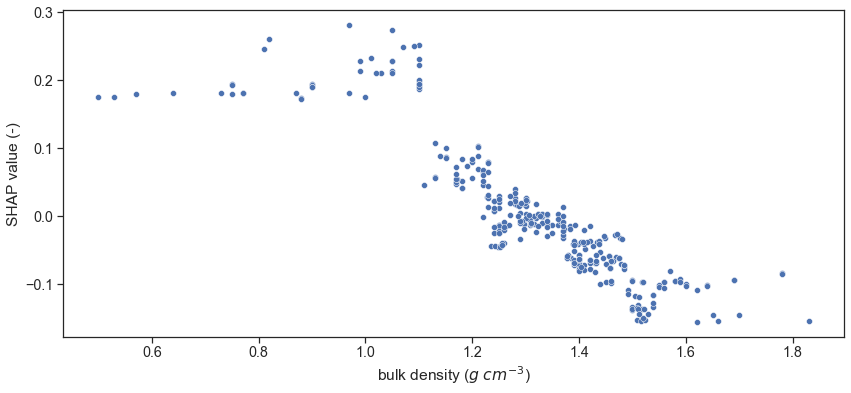

In [7]:
# Load Model Parameters
sdir = data_dir + "Success4/"
#sdir = data_dir
shap_dic = {}
bd_list = []
shap_bd_list = []
#for i, k in enumerate(k_factors):
for j in range(10): 
    shap = pd.read_csv(sdir + "Log_KsGlobalShaps_run" + str(j) + ".csv", delimiter=',')      
    Xec = pd.read_csv(sdir + "Log_KsXecSelec_run" + str(j) + ".csv", delimiter=',')       
    if j == 0:
        shap_dic = dfnow        
    else:
        shap_dic = pd.concat([shap_dic, dfnow], axis = 1)
    
    if 'BulkDensity' in shap.columns:
        bd_list.append(Xec['BulkDensity'].values)
        shap_bd_list.append(shap['BulkDensity'].values)
        
df_shap_bd = pd.DataFrame({'BD': np.hstack(bd_list), 'SHAP': np.hstack(shap_bd_list)})
#sns.scatterplot(data=df_shap_bd, x='BD', y='SHAP')
ax = sns.scatterplot(data=pd.DataFrame({'BD': bd_list[3], 'SHAP': shap_bd_list[3]}), x='BD', y='SHAP')
ax.set(xlabel='bulk density ($g\;cm^{-3}$)', ylabel='SHAP value (-)')
plt.savefig(sdir + "Pics/BulkDensity_Ks.JPEG", dpi=300, bbox_inches='tight')

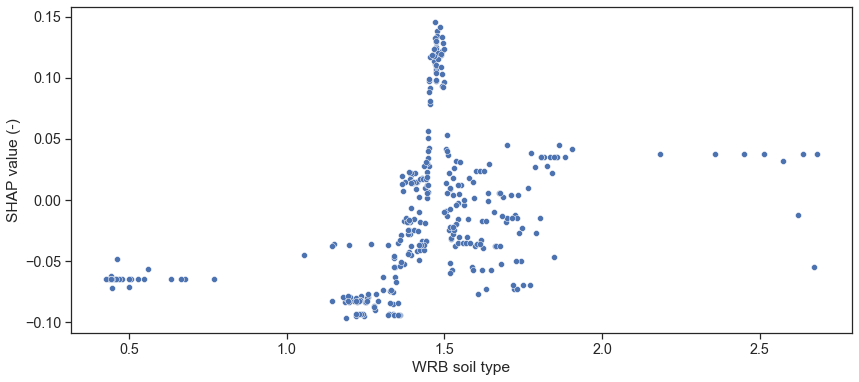

In [8]:
# Load Model Parameters
sdir = data_dir + "Success4/"
#sdir = data_dir
shap_dic = {}
bd_list = []
shap_bd_list = []
#for i, k in enumerate(k_factors):
for j in range(10): 
    shap = pd.read_csv(sdir + "Log_K1GlobalShaps_run" + str(j) + ".csv", delimiter=',')      
    Xec = pd.read_csv(sdir + "Log_K1XecSelec_run" + str(j) + ".csv", delimiter=',')       
    if j == 0:
        shap_dic = dfnow        
    else:
        shap_dic = pd.concat([shap_dic, dfnow], axis = 1)
    
    if 'SoilTypeWRB' in shap.columns:
        bd_list.append(Xec['SoilTypeWRB'].values)
        shap_bd_list.append(shap['SoilTypeWRB'].values)
        
df_shap_bd = pd.DataFrame({'WRB soil type': np.hstack(bd_list), 'SHAP': np.hstack(shap_bd_list)})
#sns.scatterplot(data=df_shap_bd, x='BD', y='SHAP')
ax = sns.scatterplot(data=pd.DataFrame({'WRB soil type': bd_list[9], 'SHAP': shap_bd_list[9]}), x='WRB soil type', y='SHAP')
ax.set(xlabel='WRB soil type', ylabel='SHAP value (-)')
plt.savefig(sdir + "Pics/SoilTypeWRB_K1.JPEG", dpi=300, bbox_inches='tight')

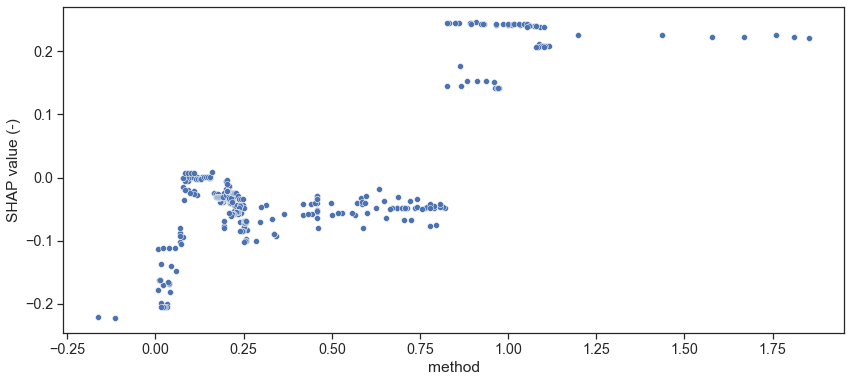

In [9]:
# Load Model Parameters
sdir = data_dir + "Success4/"
#sdir = data_dir
shap_dic = {}
bd_list = []
shap_bd_list = []
#for i, k in enumerate(k_factors):
for j in range(10): 
    shap = pd.read_csv(sdir + "Log_K10GlobalShaps_run" + str(j) + ".csv", delimiter=',')      
    Xec = pd.read_csv(sdir + "Log_K10XecSelec_run" + str(j) + ".csv", delimiter=',')       
    if j == 0:
        shap_dic = dfnow        
    else:
        shap_dic = pd.concat([shap_dic, dfnow], axis = 1)
    
    if 'Method' in shap.columns:
        bd_list.append(Xec['Method'].values)
        shap_bd_list.append(shap['Method'].values)
        
df_shap_bd = pd.DataFrame({'Method': np.hstack(bd_list), 'SHAP': np.hstack(shap_bd_list)})
#sns.scatterplot(data=df_shap_bd, x='BD', y='SHAP')
ax = sns.scatterplot(data=pd.DataFrame({'Method': bd_list[3], 'SHAP': shap_bd_list[3]}), x='Method', y='SHAP')
ax.set(xlabel='method', ylabel='SHAP value (-)')
plt.savefig(sdir + "Pics/Method_K10.JPEG", dpi=300, bbox_inches='tight')

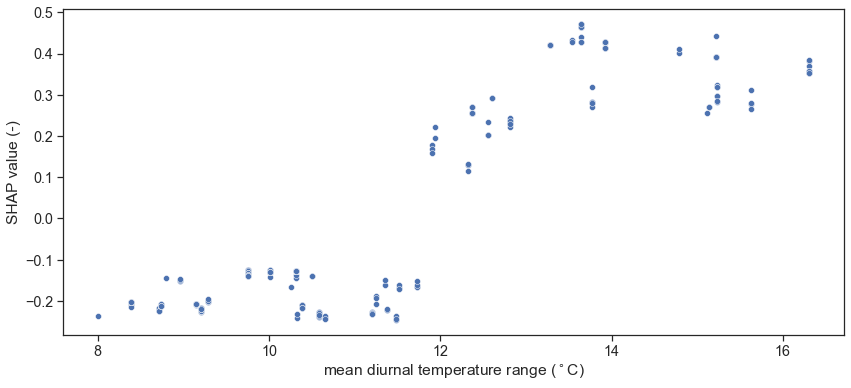

In [10]:
# Load Model Parameters
sdir = data_dir + "Success4/"
#sdir = data_dir
shap_dic = {}
bd_list = []
shap_bd_list = []
#for i, k in enumerate(k_factors):
for j in range(10): 
    shap = pd.read_csv(sdir + "Log_K10GlobalShaps_run" + str(j) + ".csv", delimiter=',')      
    Xec = pd.read_csv(sdir + "Log_K10XecSelec_run" + str(j) + ".csv", delimiter=',')       
    if j == 0:
        shap_dic = dfnow        
    else:
        shap_dic = pd.concat([shap_dic, dfnow], axis = 1)
    
    if 'MeanDiurnalRange' in shap.columns:
        bd_list.append(Xec['MeanDiurnalRange'].values)
        shap_bd_list.append(shap['MeanDiurnalRange'].values)
        
df_shap_bd = pd.DataFrame({'MeanDiurnalRange': np.hstack(bd_list), 'SHAP': np.hstack(shap_bd_list)})
#sns.scatterplot(data=df_shap_bd, x='BD', y='SHAP')
ax = sns.scatterplot(data=pd.DataFrame({'MeanDiurnalRange': bd_list[3], 'SHAP': shap_bd_list[3]}), x='MeanDiurnalRange', y='SHAP')
ax.set(xlabel='mean diurnal temperature range ($^\circ$C)', ylabel='SHAP value (-)')
plt.savefig(sdir + "Pics/MeanDiurnalRange_K10.JPEG", dpi=300, bbox_inches='tight')

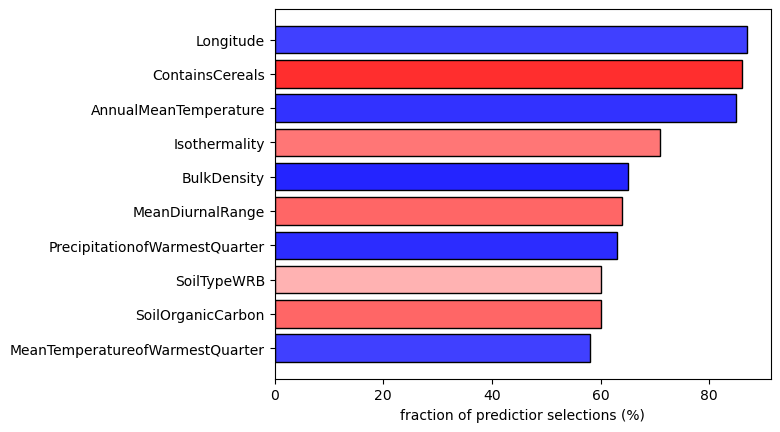

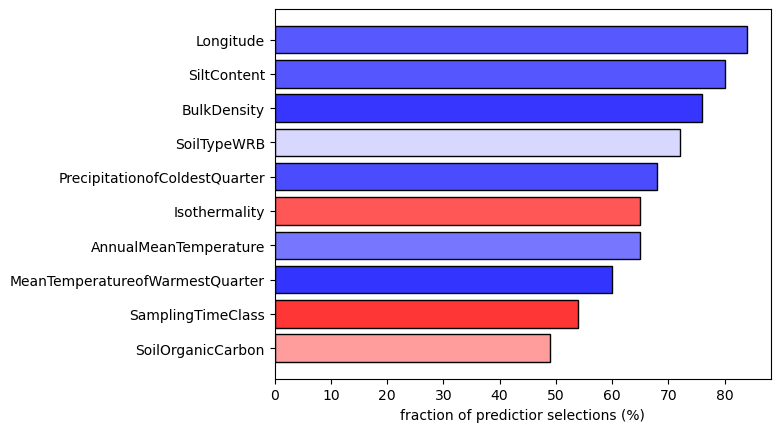

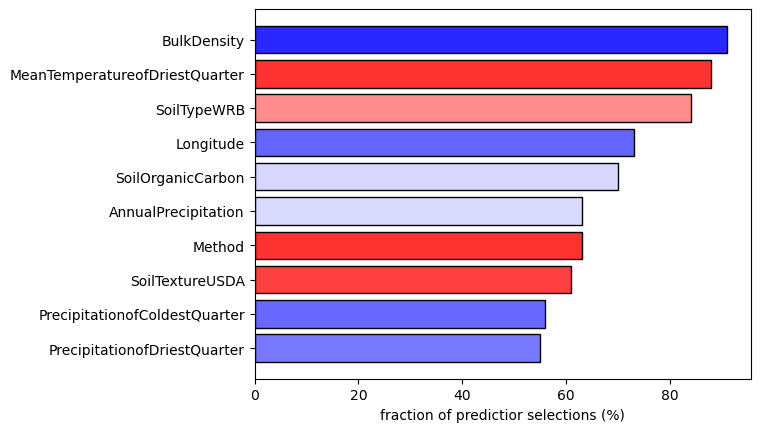

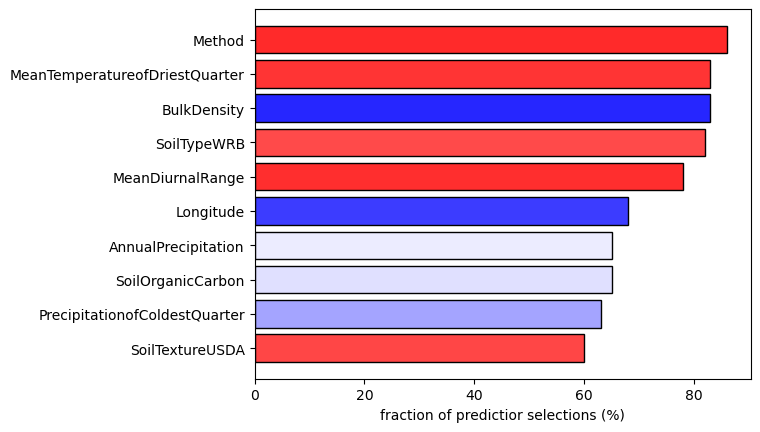

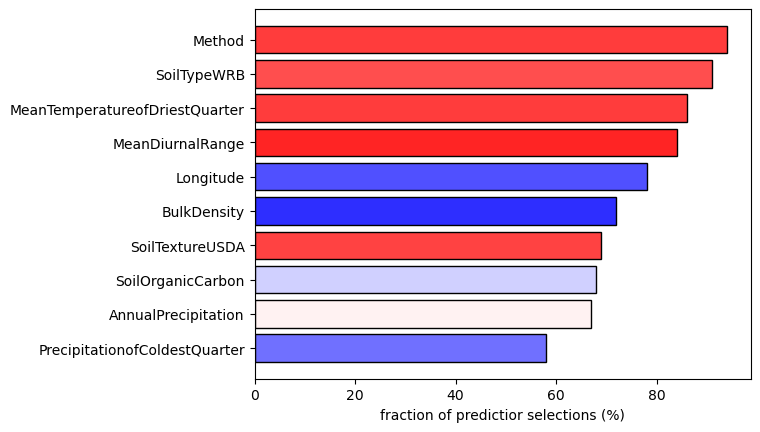

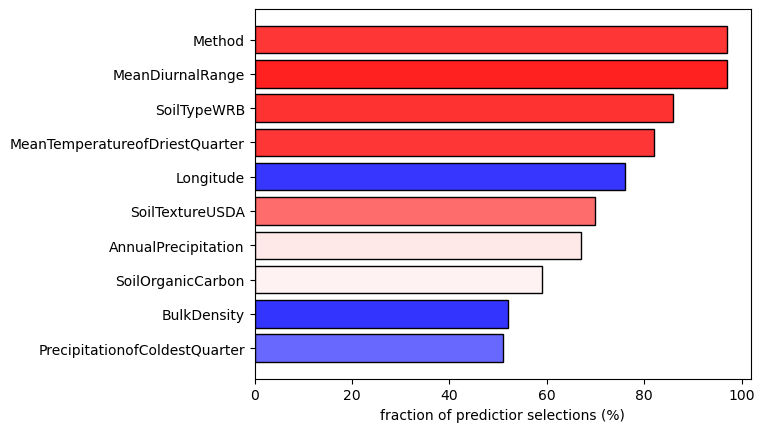

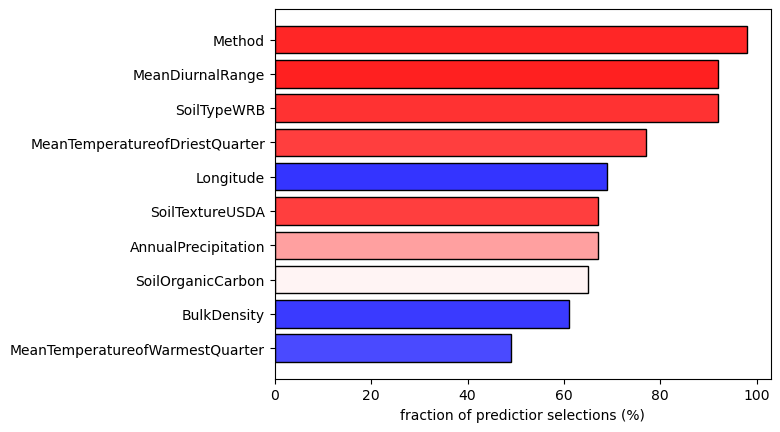

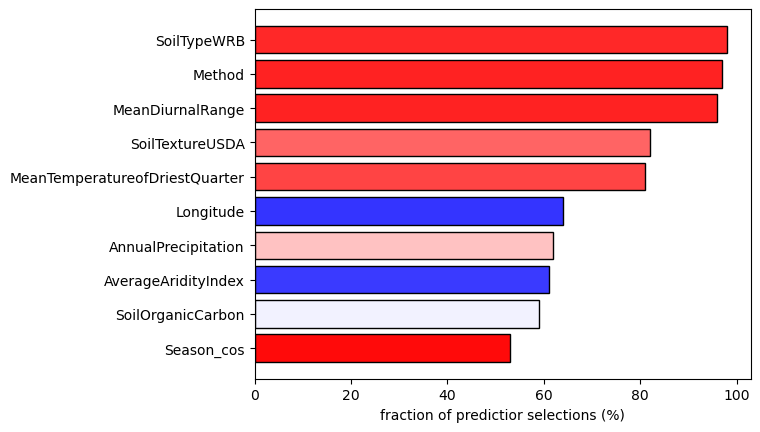

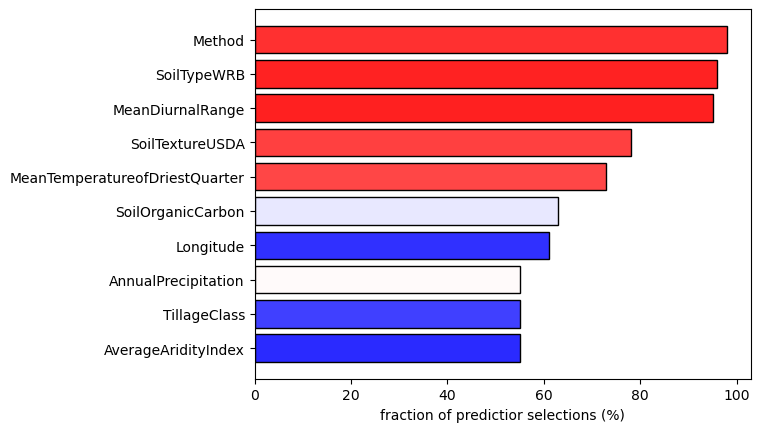

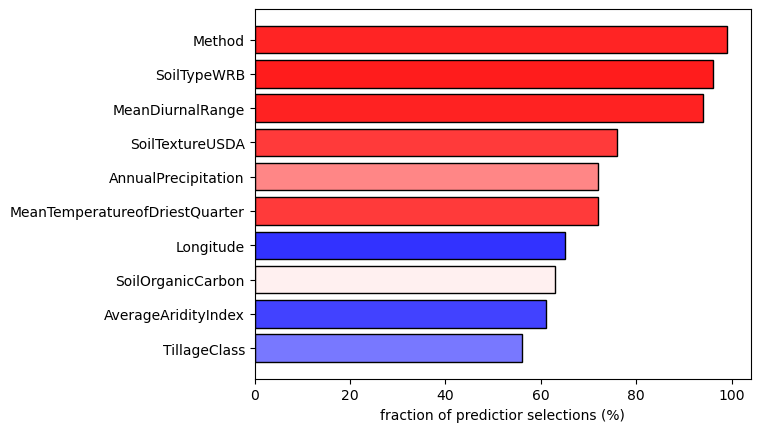

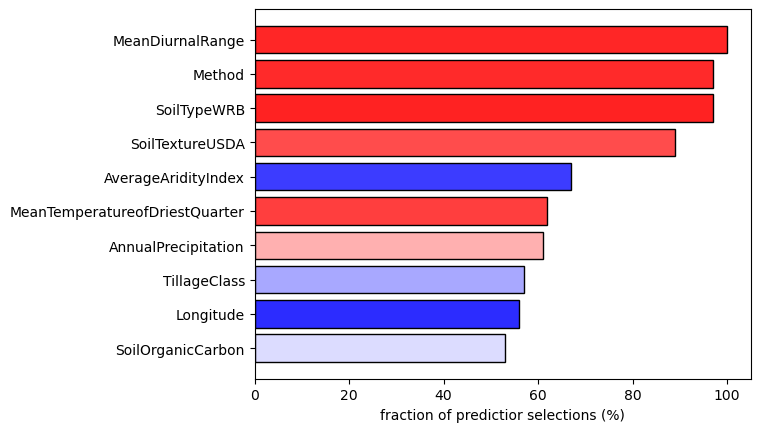

In [31]:
sdir = data_dir + "Success4/"
outfreaqs = []
    
for i, k in enumerate(k_factors):
    freaqs={}
    sfreaqs={}
    feature_list = []
    expVal_list = []
    corr_list = []
    for j in range(10): 
        with open(sdir + k + "LocalShapList_run" + str(j) + ".pkl", "rb") as f:
            nowShap = pickle.load(f)
        with open(sdir + k + "LocalExpValuesList_run" + str(j) + ".pkl", "rb") as f:
            nowExpVal = pickle.load(f)            
        with open(sdir + k + "LocalCorrList_run" + str(j) + ".pkl", "rb") as f:
            nowCorr = pickle.load(f)              
        for i in range(10):
            feature_list.append(nowShap[i].columns)
        expVal_list.append(nowExpVal)
        corr_list.append(nowCorr)

    kuntz = Counter(np.hstack(feature_list))
    freaqs = {k: c for k, c in kuntz.items() if c >= 5}
    sfreaqs = {k: c for k, c in sorted(freaqs.items(), key=lambda item: item[1], reverse=True)}
    topfreaqs = list(sfreaqs.items())[:10]
    outfreaqs.append(sfreaqs)
            
    all_corrs = corr_list[0][-1].merge(
        corr_list[1][-1], how='outer', on='Variable').merge(
        corr_list[2][-1], how='outer', on='Variable').merge(
        corr_list[3][-1], how='outer', on='Variable').merge(
        corr_list[4][-1], how='outer', on='Variable').merge(
        corr_list[5][-1], how='outer', on='Variable').merge(
        corr_list[6][-1], how='outer', on='Variable').merge(
        corr_list[7][-1], how='outer', on='Variable').merge(
        corr_list[8][-1], how='outer', on='Variable').merge(
        corr_list[9][-1], how='outer', on='Variable')

    df_corr = pd.DataFrame([all_corrs.median(axis=1)])
    df_corr.columns = all_corrs['Variable'].values
    
    rescale = lambda y: (y + 1) / 2    
    my_cmap = plt.get_cmap("bwr")
        
    keys = []
    values = []
    for j in range(len(topfreaqs)):
        keys.append(topfreaqs[j][0])
        values.append(topfreaqs[j][1])
    
    corros = []
    for j in keys:
        corros.append(np.asscalar(df_corr[j].values))

    plt.rcdefaults()
    fig, ax = plt.subplots()
    y_pos = np.arange(len(topfreaqs))
    p = ax.barh(y_pos, values,color=my_cmap(rescale(np.asarray(corros))), linewidth=1, edgecolor='black')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(keys)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('fraction of predictior selections (%)')

    plt.savefig(sdir + "Pics/Selecs_" + k + ".JPEG", dpi=300, bbox_inches='tight')

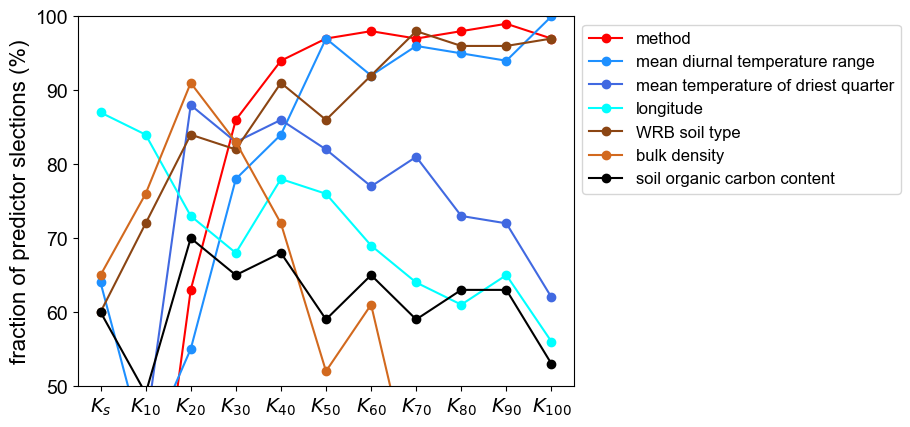

In [34]:
meth = []
mdr = []
bd = []
longi = []
lati = []
wrb = []
mtodq = []
usda = []
soc = []
for i in range(len(outfreaqs)):
    if 'Method' in outfreaqs[i]: 
        meth.append(outfreaqs[i]['Method'])
    mdr.append(outfreaqs[i]['MeanDiurnalRange'])
    bd.append(outfreaqs[i]['BulkDensity'])
    longi.append(outfreaqs[i]['Longitude'])
    wrb.append(outfreaqs[i]['SoilTypeWRB'])
    if 'MeanTemperatureofDriestQuarter' in outfreaqs[i]: 
        mtodq.append(outfreaqs[i]['MeanTemperatureofDriestQuarter'])
    usda.append(outfreaqs[i]['SoilTextureUSDA']) 
    soc.append(outfreaqs[i]['SoilOrganicCarbon']) 
    
fig, ax = plt.subplots()
lablist = [0] * 7
lablist[0] = plt.plot(list(range(0, 11)), meth,'-o',color="red")
lablist[1] = plt.plot(mdr,'-o',color="dodgerblue")
lablist[2] = plt.plot(mtodq,'-o',color="royalblue")
lablist[3] = plt.plot(longi,'-o',color="cyan")
lablist[4] = plt.plot(wrb,'-o',color="saddlebrown")
lablist[5] = plt.plot(bd,'-o',color="chocolate")
lablist[6] = plt.plot(soc,'-o',color="black")
ax.set_ylim(50, 100)
ax.set_yticks(list(range(50,101,10)))
ax.set_yticklabels(list(range(50,101,10)), fontname='Arial', fontsize=14)
ax.set_ylabel("fraction of predictor slections (%)", fontname='Arial', fontsize=16)
ax.set_xticks(list(range(0,11)))
ax.set_xticklabels(['$K_s$','$K_{10}$','$K_{20}$','$K_{30}$','$K_{40}$','$K_{50}$','$K_{60}$','$K_{70}$','$K_{80}$','$K_{90}$','$K_{100}$'], fontname='Arial', fontsize=14)
ax.legend(lablist, labels= ['method','mean diurnal temperature range','mean temperature of driest quarter','longitude','WRB soil type','bulk density','soil organic carbon content'], bbox_to_anchor =(1, 1), prop={"family": "Arial", "size":12})
plt.savefig(sdir + "Pics/SomeTopSelecs.JPEG", dpi=300, bbox_inches='tight')

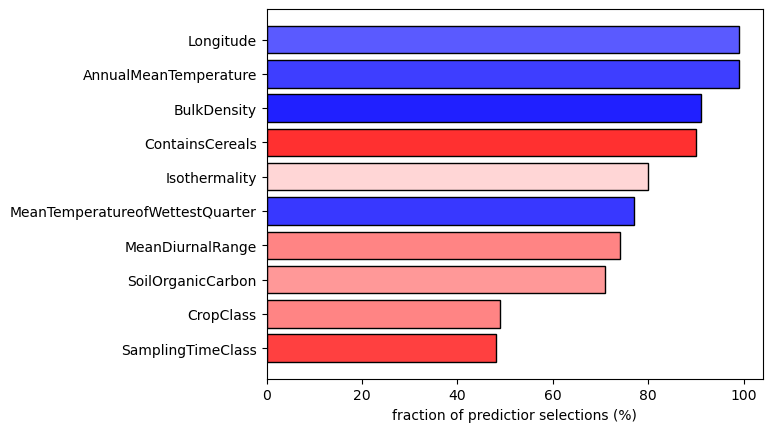

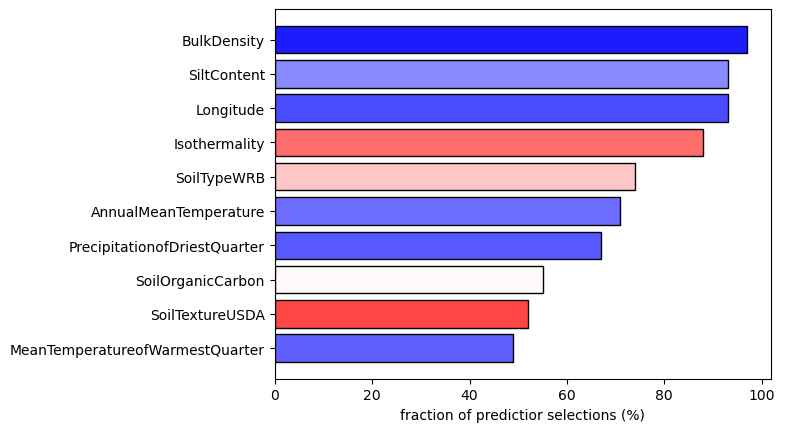

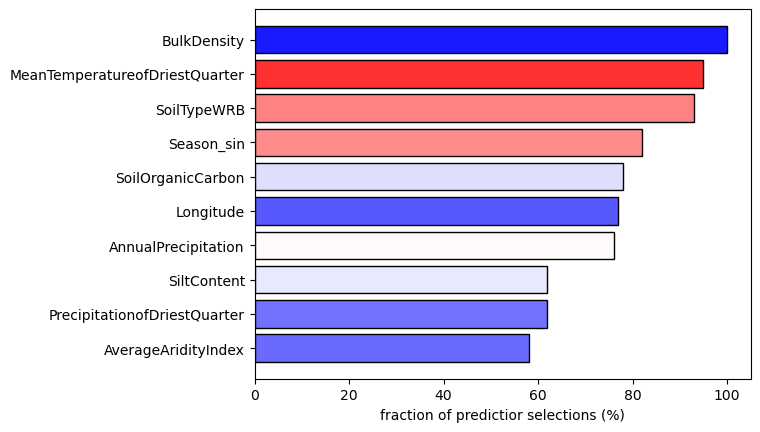

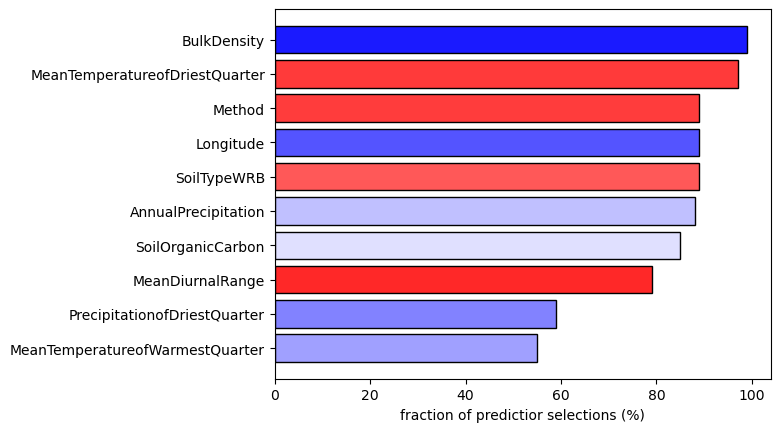

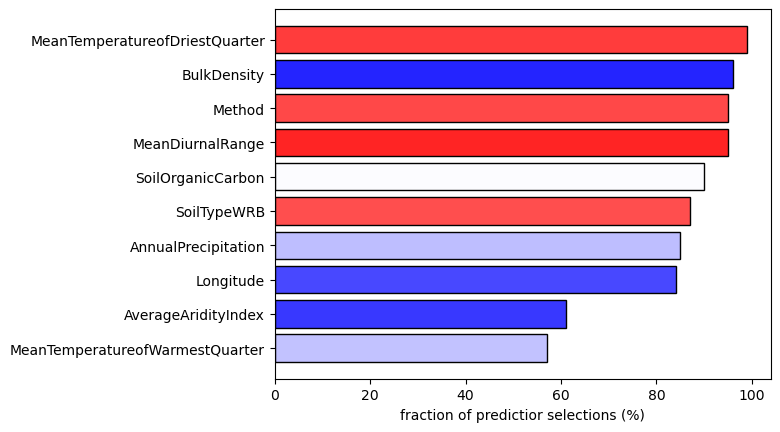

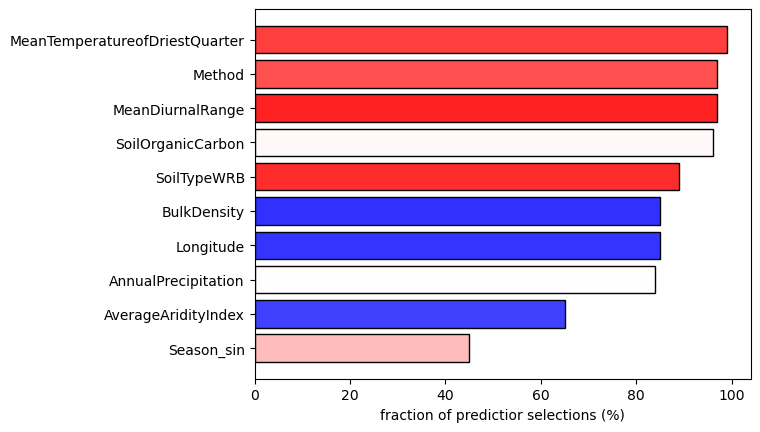

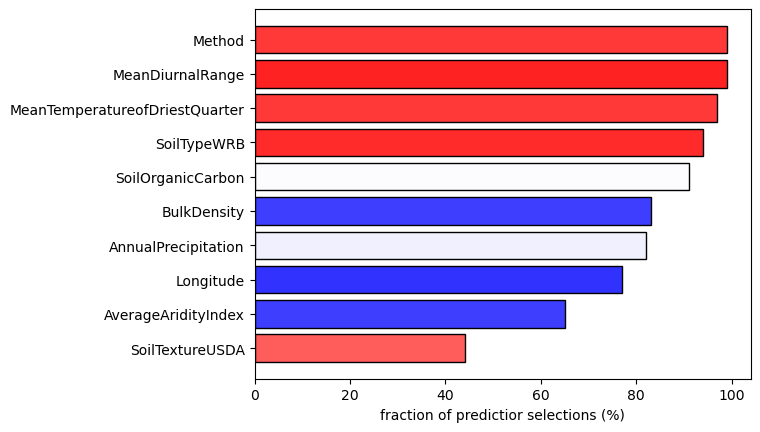

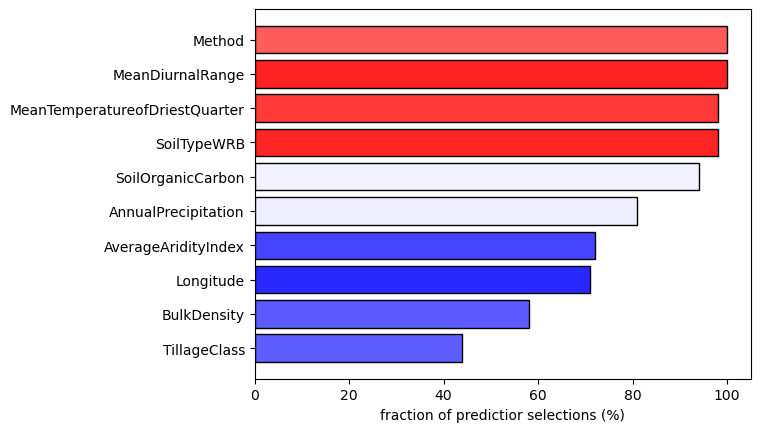

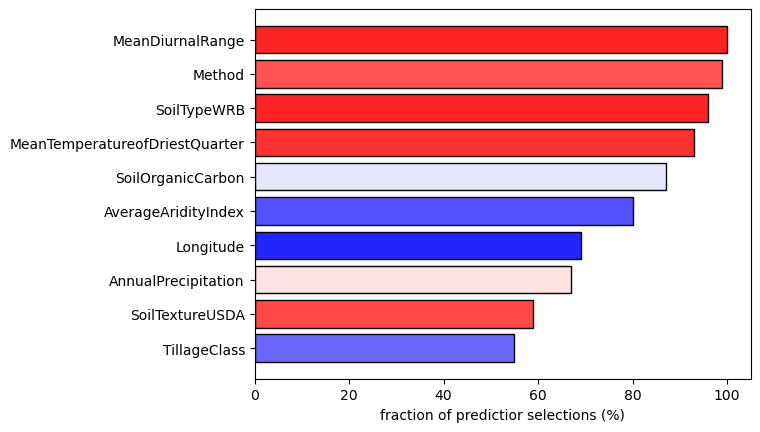

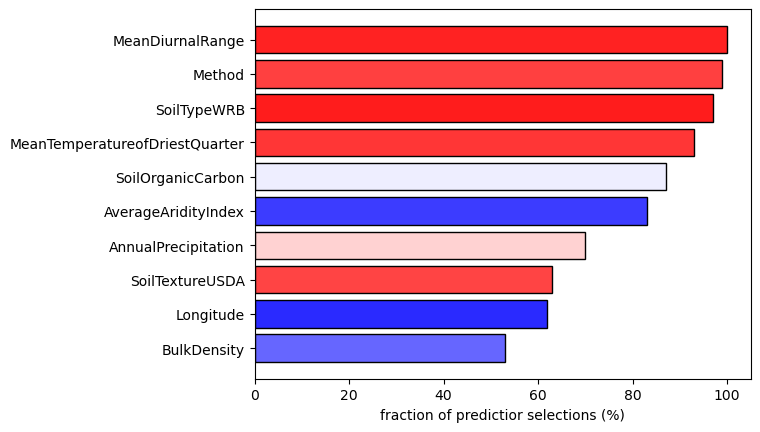

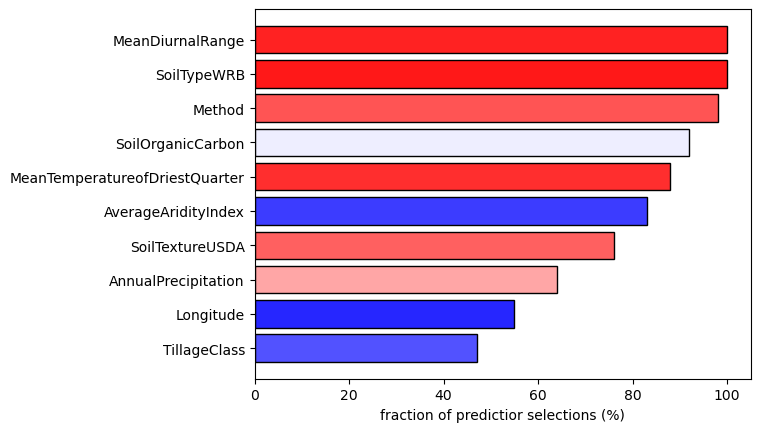

In [14]:
sdir = data_dir + "Naive2/"
outfreaqs = []
    
for i, k in enumerate(k_factors):
    freaqs={}
    sfreaqs={}
    feature_list = []
    expVal_list = []
    corr_list = []
    for j in range(10): 
        with open(sdir + k + "LocalShapList_run" + str(j) + ".pkl", "rb") as f:
            nowShap = pickle.load(f)
        with open(sdir + k + "LocalExpValuesList_run" + str(j) + ".pkl", "rb") as f:
            nowExpVal = pickle.load(f)            
        with open(sdir + k + "LocalCorrList_run" + str(j) + ".pkl", "rb") as f:
            nowCorr = pickle.load(f)              
        for i in range(10):
            feature_list.append(nowShap[i].columns)
        expVal_list.append(nowExpVal)
        corr_list.append(nowCorr)

    kuntz = Counter(np.hstack(feature_list))
    freaqs = {k: c for k, c in kuntz.items() if c >= 5}
    sfreaqs = {k: c for k, c in sorted(freaqs.items(), key=lambda item: item[1], reverse=True)}
    topfreaqs = list(sfreaqs.items())[:10]
    outfreaqs.append(sfreaqs)
            
    all_corrs = corr_list[0][-1].merge(
        corr_list[1][-1], how='outer', on='Variable').merge(
        corr_list[2][-1], how='outer', on='Variable').merge(
        corr_list[3][-1], how='outer', on='Variable').merge(
        corr_list[4][-1], how='outer', on='Variable').merge(
        corr_list[5][-1], how='outer', on='Variable').merge(
        corr_list[6][-1], how='outer', on='Variable').merge(
        corr_list[7][-1], how='outer', on='Variable').merge(
        corr_list[8][-1], how='outer', on='Variable').merge(
        corr_list[9][-1], how='outer', on='Variable')

    df_corr = pd.DataFrame([all_corrs.median(axis=1)])
    df_corr.columns = all_corrs['Variable'].values
    
    rescale = lambda y: (y + 1) / 2    
    my_cmap = plt.get_cmap("bwr")
        
    keys = []
    values = []
    for j in range(len(topfreaqs)):
        keys.append(topfreaqs[j][0])
        values.append(topfreaqs[j][1])
    
    corros = []
    for j in keys:
        corros.append(np.asscalar(df_corr[j].values))

    plt.rcdefaults()
    fig, ax = plt.subplots()
    y_pos = np.arange(len(topfreaqs))
    p = ax.barh(y_pos, values,color=my_cmap(rescale(np.asarray(corros))), linewidth=1, edgecolor='black')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(keys)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('fraction of predictior selections (%)')

    plt.savefig(sdir + "Pics/NaiveSelecs_" + k + ".JPEG", dpi=300, bbox_inches='tight')

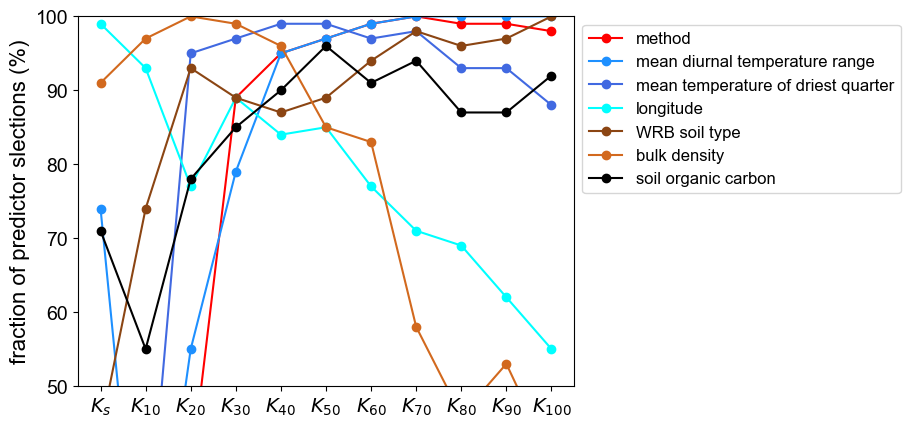

In [29]:
meth = []
mdr = []
bd = []
longi = []
lati = []
wrb = []
mtodq = []
usda = []
soc = []
for i in range(len(outfreaqs)):
    if 'Method' in outfreaqs[i]: 
        meth.append(outfreaqs[i]['Method'])
    mdr.append(outfreaqs[i]['MeanDiurnalRange'])
    bd.append(outfreaqs[i]['BulkDensity'])
    longi.append(outfreaqs[i]['Longitude'])
    wrb.append(outfreaqs[i]['SoilTypeWRB'])
    if 'MeanTemperatureofDriestQuarter' in outfreaqs[i]: 
        mtodq.append(outfreaqs[i]['MeanTemperatureofDriestQuarter'])
    usda.append(outfreaqs[i]['SoilTextureUSDA']) 
    soc.append(outfreaqs[i]['SoilOrganicCarbon']) 
    
fig, ax = plt.subplots()
lablist = [0] * 7
lablist[0] = plt.plot(list(range(2, 11)), meth,'-o',color="red")
lablist[1] = plt.plot(mdr,'-o',color="dodgerblue")
lablist[2] = plt.plot(list(range(1, 11)), mtodq,'-o',color="royalblue")
lablist[3] = plt.plot(longi,'-o',color="cyan")
lablist[4] = plt.plot(wrb,'-o',color="saddlebrown")
#lablist[5] = plt.plot(usda,'-o',color="chocolate")
lablist[5] = plt.plot(bd,'-o',color="chocolate")
lablist[6] = plt.plot(soc,'-o',color="black")
ax.set_ylim(50, 100)
ax.set_yticks(list(range(50,101,10)))
ax.set_yticklabels(list(range(50,101,10)), fontname='Arial', fontsize=14)
ax.set_ylabel("fraction of predictor slections (%)", fontname='Arial', fontsize=16)
ax.set_xticks(list(range(0,11)))
ax.set_xticklabels(['$K_s$','$K_{10}$','$K_{20}$','$K_{30}$','$K_{40}$','$K_{50}$','$K_{60}$','$K_{70}$','$K_{80}$','$K_{90}$','$K_{100}$'], fontname='Arial', fontsize=14)
ax.legend(lablist, labels= ['method','mean diurnal temperature range','mean temperature of driest quarter','longitude','WRB soil type','bulk density','soil organic carbon'], bbox_to_anchor =(1, 1), prop={"family": "Arial", "size":12})
plt.savefig(sdir + "Pics/SomeNaiveTopSelecs.JPEG", dpi=300, bbox_inches='tight')

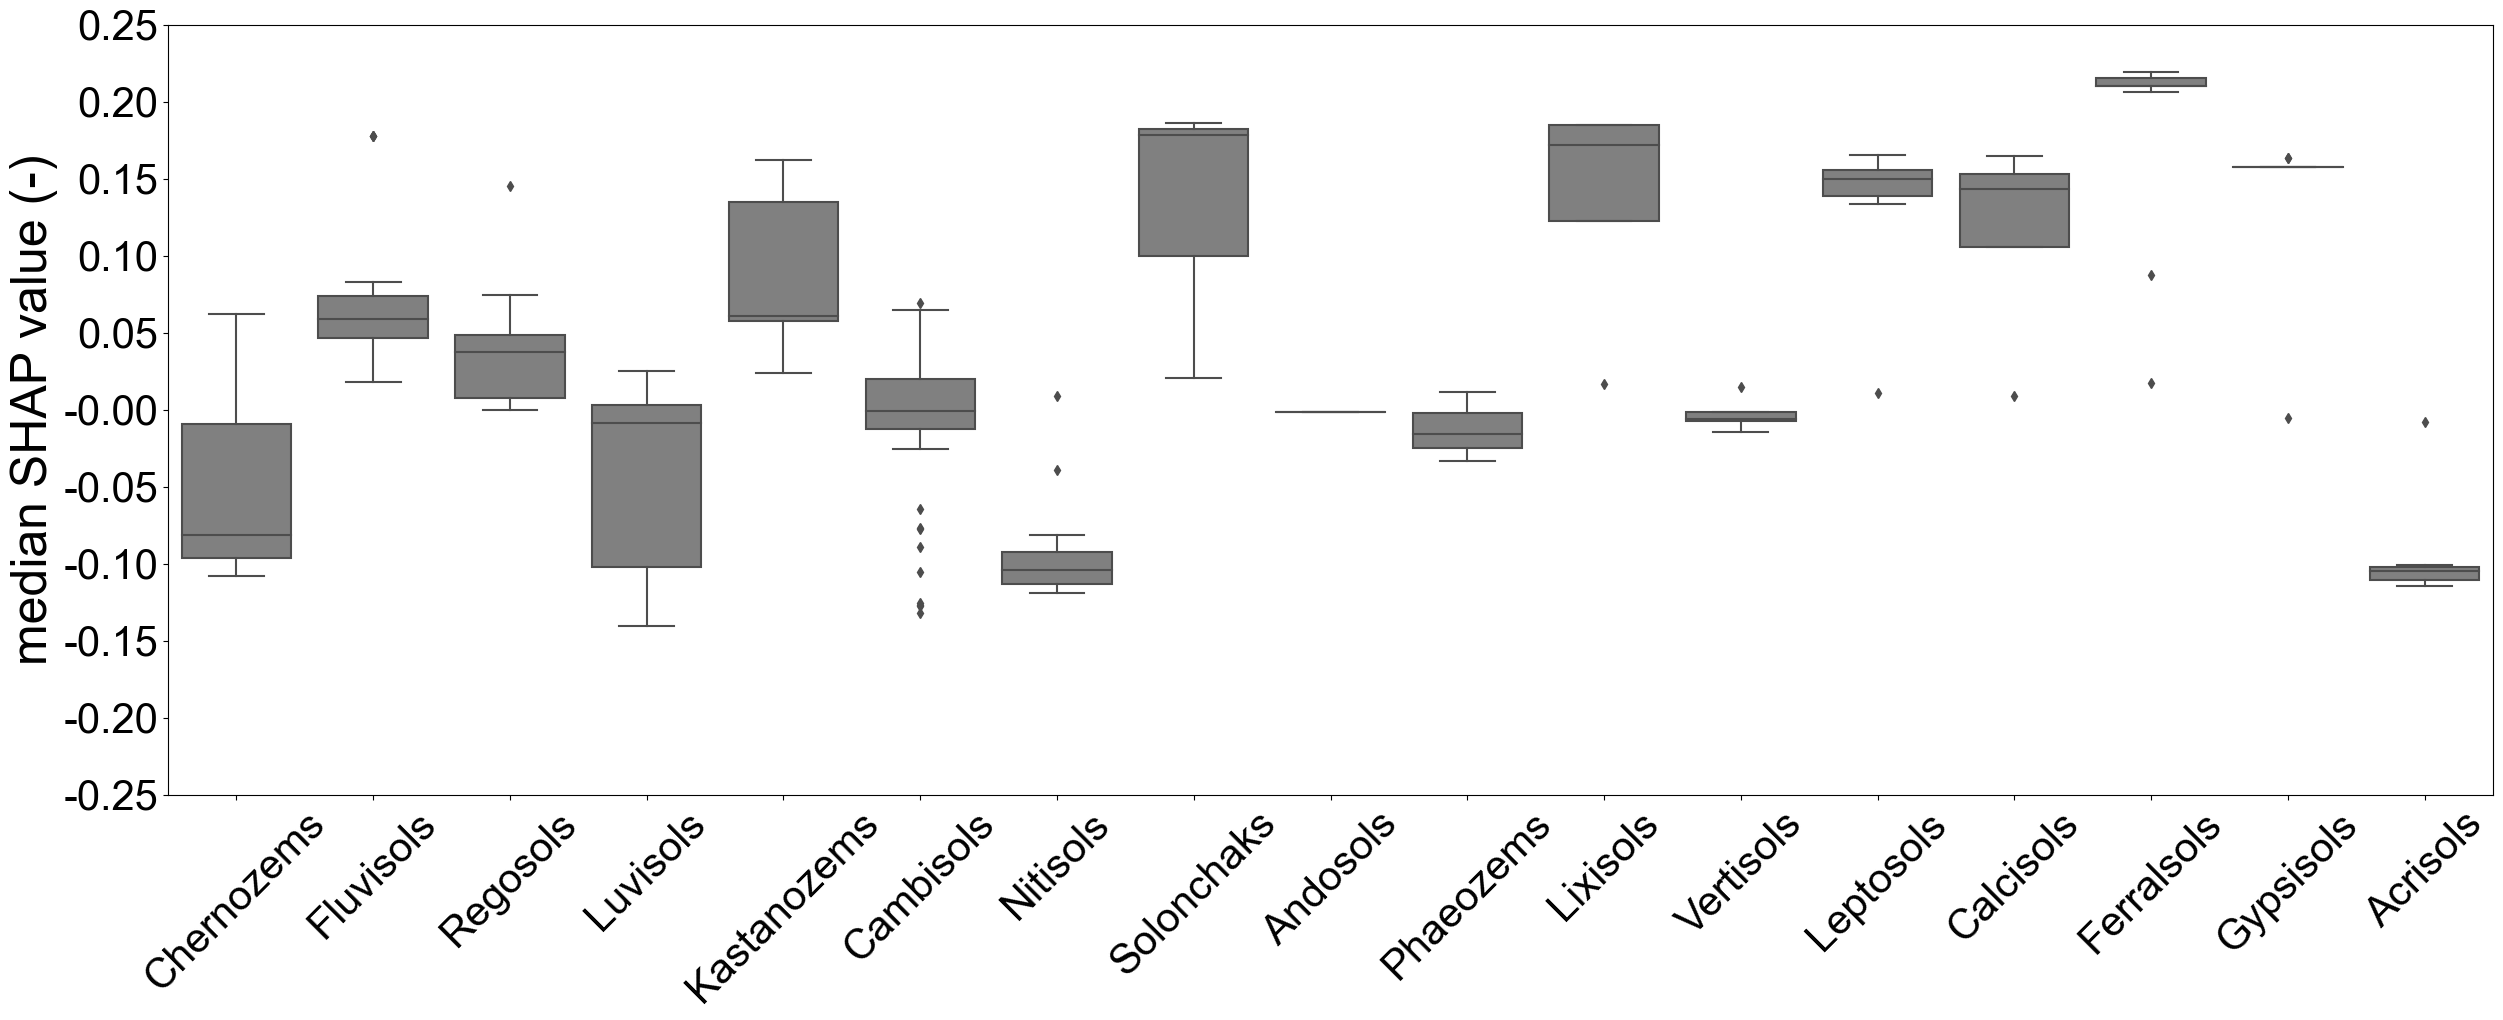

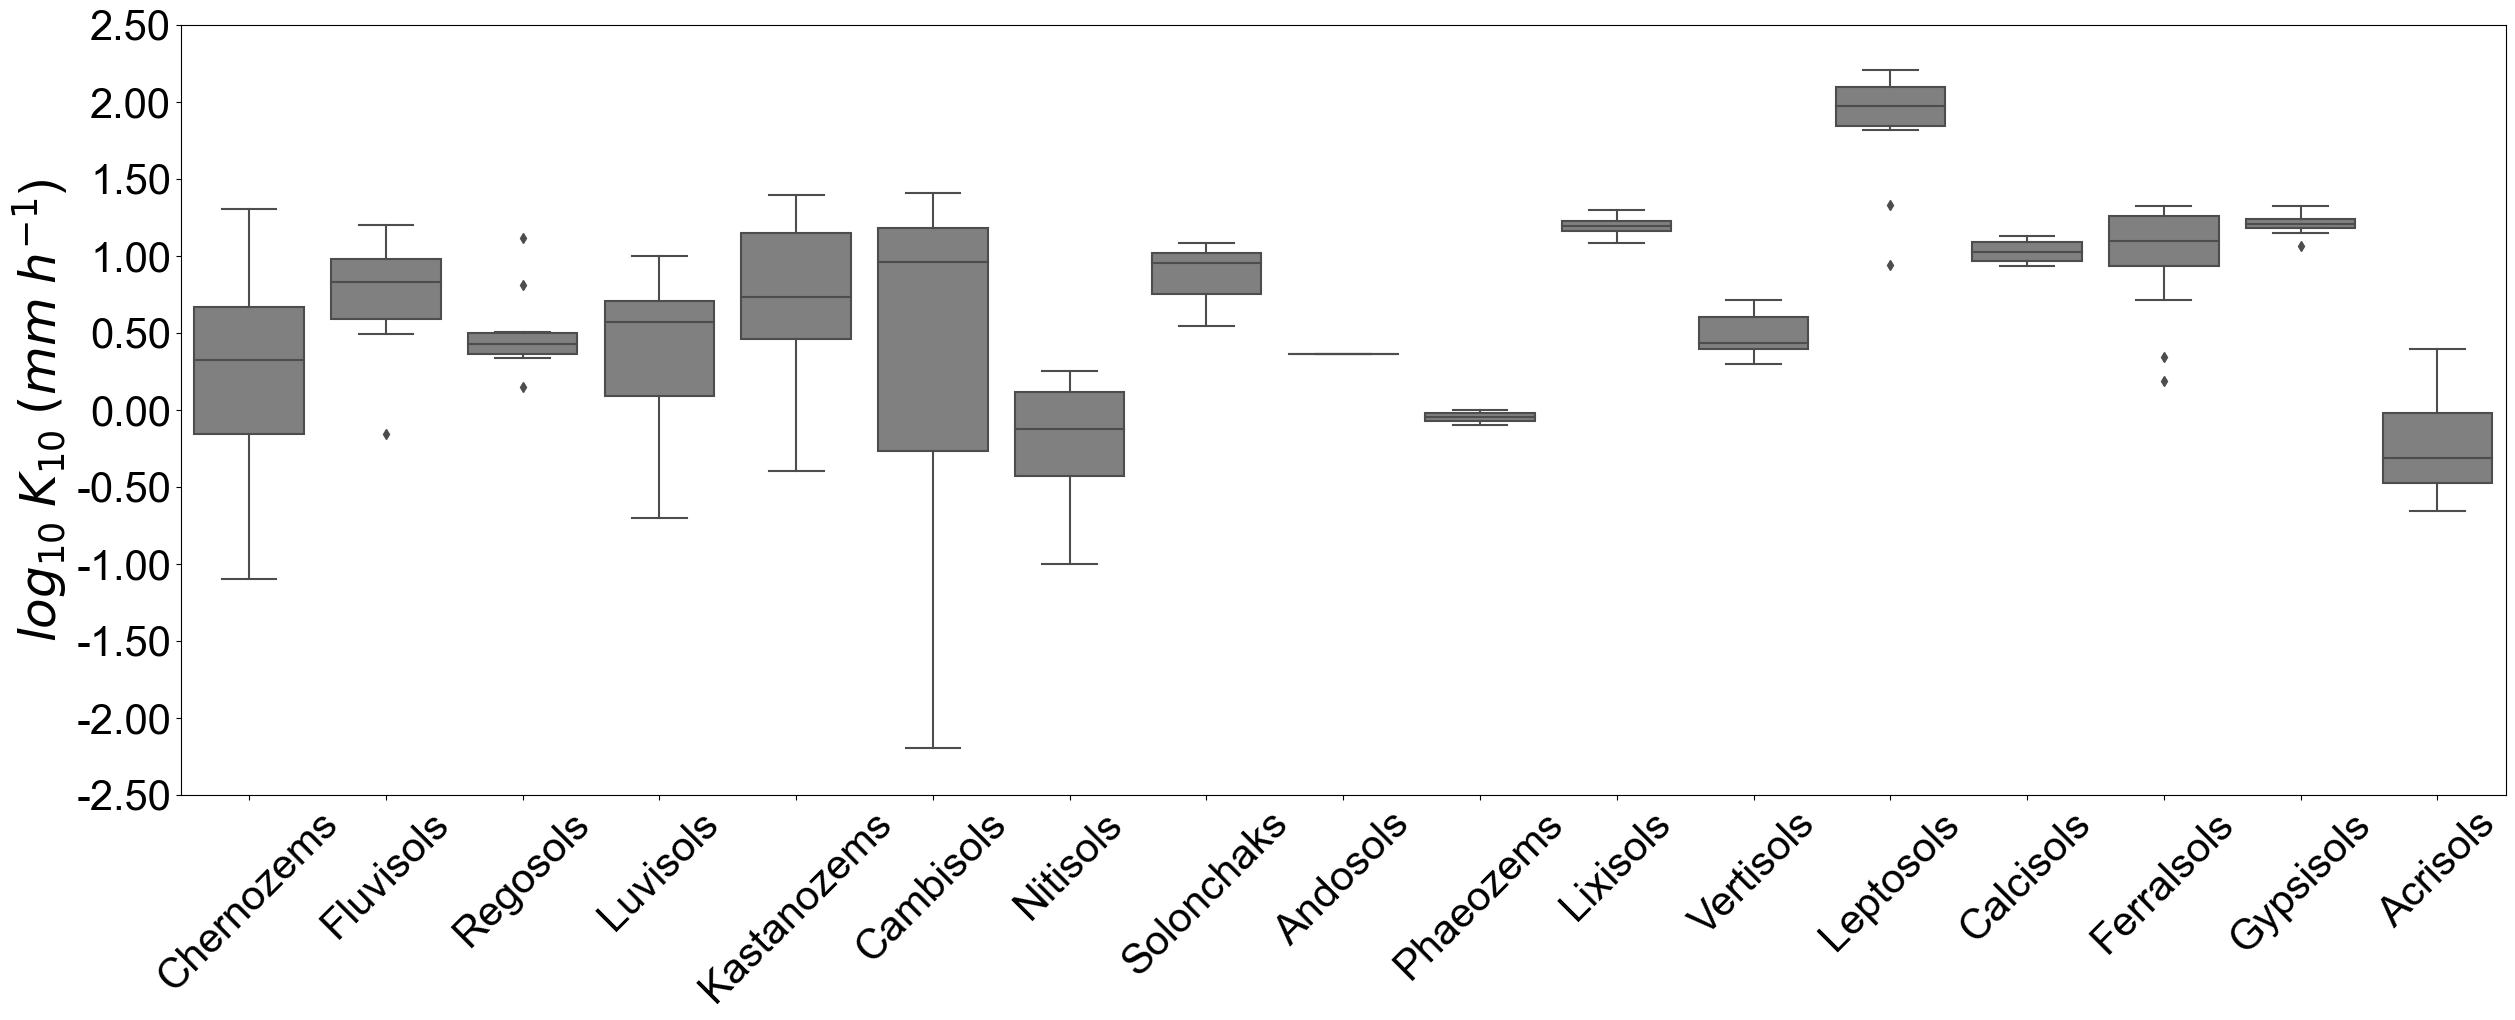

In [18]:
sdir = data_dir + "Success4/"
dfK10enco = pd.read_csv(data_dir + "log_K10_encoded.csv", delimiter=',')      
dfK10pure = pd.read_csv(data_dir + "log_K10_original.csv", delimiter=',')  
dfK10pure = dfK10pure.rename(columns = {'SoilTypeWRB': 'original'})
dfK10 = dfK10enco[['SoilTypeWRB','log_K10']].join(dfK10pure['original'])

shaplist = []
for i in range(10):
    dfs = pd.read_csv(sdir + "log_K10GlobalShaps_run"+str(i)+".csv", delimiter=',')      
    dfs = dfs.rename(columns={'SoilTypeWRB': 'SoilTypeWRB'+str(i)})
    if i == 0:        
        dfshap = dfs[['SoilTypeWRB'+str(i),'TillageClass']]
    else:
        dfshap = dfshap.join(dfs['SoilTypeWRB'+str(i)])
dfshap = dfshap.drop(columns=['TillageClass'])
dfs = pd.DataFrame(dfshap.median(axis=1), columns=['medianShap'])
dfK10 = dfK10.join(dfs)

labellist = []
for i in np.arange(-0.25, 0.251, 0.05): labellist.append("{:.2f}".format(i))

fig, axes = plt.subplots(figsize=(30, 10))
g1 = sns.boxplot(x="original", y="medianShap", data=dfK10, color = 'grey')
g1.set(xlabel=None, ylim=(-0.25, 0.25))
g1.set_xticklabels(dfK10['original'].unique(), fontname='Arial', fontsize=30, rotation=45)
g1.set_ylabel("median SHAP value (-)", fontname='Arial', fontsize=36)
g1.set_yticks(np.arange(-0.25, 0.251, 0.05))
g1.set_yticklabels(labellist, fontname='Arial', fontsize=30)

plt.savefig(sdir + "Pics/WRBSoilTypeEncodings_K10.JPEG", dpi=300, bbox_inches='tight')

labellist = []
for i in np.arange(-2.5, 2.51, 0.5): labellist.append("{:.2f}".format(i))

fig, axes = plt.subplots(figsize=(30, 10))
g1 = sns.boxplot(x="original", y="log_K10", data=dfK10, color = 'grey')
g1.set(xlabel=None, ylim=(-2.5, 2.5))
g1.set_xticklabels(dfK10['original'].unique(), fontname='Arial', fontsize=30, rotation=45)
g1.set_ylabel("$log_{10}\;K_{10}\;(mm\;h^{-1}$)", fontname='Arial', fontsize=36)
g1.set_yticks(np.arange(-2.5, 2.51, 0.5))
g1.set_yticklabels(labellist, fontname='Arial', fontsize=30)

plt.savefig(sdir + "Pics/WRBSoilType_K10.JPEG", dpi=300, bbox_inches='tight')

In [ ]:
sdir = data_dir + "Success4/"
dfK10enco = pd.read_csv(data_dir + "log_K10_encoded.csv", delimiter=',')      
dfK10pure = pd.read_csv(data_dir + "log_K10_original.csv", delimiter=',')  
dfK10pure = dfK10pure.rename(columns = {'SoilTextureUSDA': 'original'})
dfK10 = dfK10enco[['SoilTextureUSDA','log_K10']].join(dfK10pure['original'])

shaplist = []
for i in range(10):
    dfs = pd.read_csv(sdir + "log_K10GlobalShaps_run"+str(i)+".csv", delimiter=',')      
    dfs = dfs.rename(columns={'SoilTextureUSDA': 'SoilTextureUSDA'+str(i)})
    if i == 0:        
        dfshap = dfs[['SoilTextureUSDA'+str(i),'TillageClass']]
    else:
        dfshap = dfshap.join(dfs['SoilTextureUSDA'+str(i)])
dfshap = dfshap.drop(columns=['TillageClass'])
dfs = pd.DataFrame(dfshap.median(axis=1), columns=['medianShap'])
dfK10 = dfK10.join(dfs)

labellist = []
for i in np.arange(-0.1, 0.11, 0.025): labellist.append("{:.2f}".format(i))

fig, axes = plt.subplots(figsize=(30, 10))
g1 = sns.boxplot(x="original", y="medianShap", data=dfK10, color = 'grey')
g1.set(xlabel=None, ylim=(-0.1, 0.1))
g1.set_xticklabels(dfK10['original'].unique(), fontname='Arial', fontsize=24, rotation=45)
g1.set_ylabel("median SHAP value (-)", fontname='Arial', fontsize=28, fontweight="bold")
g1.set_yticks(np.arange(-0.1, 0.11, 0.025))
g1.set_yticklabels(labellist, fontname='Arial', fontsize=24)

plt.savefig(sdir + "Pics/SoilTextureUSDAEncodings_K10.JPEG", dpi=300, bbox_inches='tight')

labellist = []
for i in np.arange(-2.5, 2.51, 0.5): labellist.append("{:.2f}".format(i))

fig, axes = plt.subplots(figsize=(30, 10))
g1 = sns.boxplot(x="original", y="log_K10", data=dfK10, color = 'grey')
g1.set(xlabel=None, ylim=(-2.5, 2.5))
g1.set_xticklabels(dfK10['original'].unique(), fontname='Arial', fontsize=24, rotation=45)
g1.set_ylabel("$log_{10}\;K_{10}\;(mm\;h^{-1}$)", fontname='Arial', fontsize=28, fontweight="bold")
g1.set_yticks(np.arange(-2.5, 2.51, 0.5))
g1.set_yticklabels(labellist, fontname='Arial', fontsize=24)

plt.savefig(sdir + "Pics/SoilTextureUSDA_K10.JPEG", dpi=300, bbox_inches='tight')

## Load Model Parameters

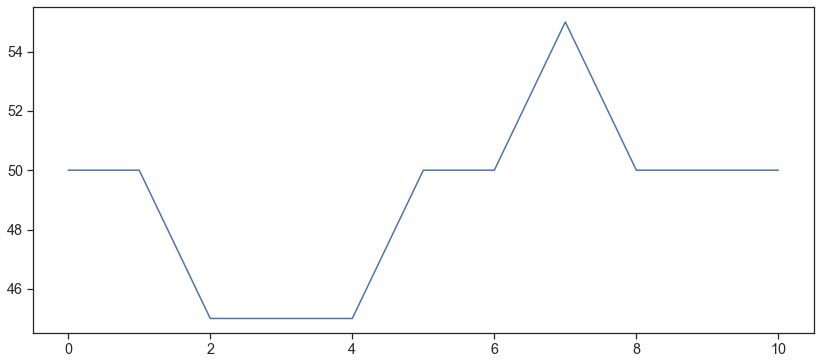

In [52]:
# # Load Model Parameters
# s3dir = data_dir + "Success3/"
# alpha_list = {}
# medAlpha = np.zeros(11)
# for i, k in enumerate(k_factors):
#     for j in range(10): 
#         dfnow = pd.read_csv(s3dir + k + "_run" + str(j) + ".csv", delimiter=',')      
#         dfnow = dfnow[["study2_reg_alpha"]]
#         dfnow = dfnow.rename(columns={"study2_reg_alpha": (k + "_alpha_run" + str(j))})
#         if j == 0:
#             alphas = dfnow        
#         else:
#             alphas = pd.concat([alphas, dfnow], axis = 1)
#     alpha_list[i] = alphas
#     medAlpha[i] = pd.melt(alpha_list[i]).median()
# plt.plot(medAlpha)

# lambda_list = {}
# medLambda = np.zeros(11)
# for i, k in enumerate(k_factors):
#     for j in range(10): 
#         dfnow = pd.read_csv(s3dir + k + "_run" + str(j) + ".csv", delimiter=',')      
#         dfnow = dfnow[["study2_reg_lambda"]]
#         dfnow = dfnow.rename(columns={"study2_reg_lambda": (k + "_lambda_run" + str(j))})
#         if j == 0:
#             lambdas = dfnow        
#         else:
#             lambdas = pd.concat([lambdas, dfnow], axis = 1)
#     lambda_list[i] = lambdas
#     medLambda[i] = pd.melt(lambda_list[i]).median()
# plt.plot(medLambda)

# ms2g_list = {}
# medms2g = np.zeros(11)
# for i, k in enumerate(k_factors):
#     for j in range(10): 
#         dfnow = pd.read_csv(s2dir + k + "_run" + str(j) + ".csv", delimiter=',')      
#         dfnow = dfnow[["study2_min_split_gain"]]
#         dfnow = dfnow.rename(columns={"study2_min_split_gain": (k + "_ms2g_run" + str(j))})
#         if j == 0:
#             ms2gs = dfnow        
#         else:
#             ms2gs = pd.concat([ms2gs, dfnow], axis = 1)
#     ms2g_list[i] = ms2gs
#     medms2g[i] = pd.melt(ms2g_list[i]).median()
# plt.plot(medms2g)

mcs_list = {}
medmcs = np.zeros(11)
for i, k in enumerate(k_factors):
    for j in range(10): 
        dfnow = pd.read_csv(s2dir + k + "_run" + str(j) + ".csv", delimiter=',')      
        dfnow = dfnow[["study2_min_child_samples"]]
        dfnow = dfnow.rename(columns={"study2_min_child_samples": (k + "_mcs_run" + str(j))})
        if j == 0:
            mcss = dfnow        
        else:
            mcss = pd.concat([mcss, dfnow], axis = 1)
    mcs_list[i] = mcss
    medmcs[i] = pd.melt(mcs_list[i]).median()
plt.plot(medmcs)